In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%tensorflow_version 1.x

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

In [0]:
# Set some parameters
im_width = 512
im_height = 512
border = 5

In [0]:
ids = next(os.walk("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/TissueImages/"))[2] # list of names all images in the given path
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [0]:
ids_test = next(os.walk("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/TissueImages/"))[2] # list of names all images in the given path
X_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)

In [22]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Training/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [23]:
#2nd change
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("/content/gdrive/My Drive/avc-dataset/MonuSeg/Test/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print ("X_train: ", np.shape(X_train), "\nY_train: ", np.shape(y_train))
print ("X_valid: ", np.shape(X_valid), "\nY_valid: ", np.shape(y_valid))
print ("X_test: ", np.shape(X_test), "\nY_test: ", np.shape(y_test))

X_train:  (24, 512, 512, 1) 
Y_train:  (24, 512, 512, 1)
X_valid:  (6, 512, 512, 1) 
Y_valid:  (6, 512, 512, 1)
X_test:  (14, 512, 512, 1) 
Y_test:  (14, 512, 512, 1)


In [0]:
# Define Some metrics
## Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
## F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model
from keras.layers import Layer

class MaxPooling2DWithIndices(Layer):
    def __init__(self, pool_size, strides, padding='SAME', **kwargs):
        super(MaxPooling2DWithIndices, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        return

    def call(self, x):
        pool_size = self.pool_size
        strides = self.strides
        if isinstance(pool_size, int): ps = [1, pool_size, pool_size, 1]
        else: ps = [1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int): st = [1, strides, strides, 1]
        else: st = [1, strides[0], strides[1], 1]
        mpooled, indices = tf.nn.max_pool_with_argmax(x, ps, st, self.padding)
        return [mpooled, indices]

    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape = (input_shape[0], input_shape[1]//self.pool_size, input_shape[2]//self.pool_size, input_shape[3])
        else: output_shape = (input_shape[0], input_shape[1]//self.pool_size[0], input_shape[2]//self.pool_size[1], input_shape[3])
        return [output_shape,output_shape]

class MaxUnpooling2DWithIndices(Layer):
    def __init__(self, **kwargs):
        super(MaxUnpooling2DWithIndices, self).__init__(**kwargs)
        return
        
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output

    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

class SegNet:
    def __init__(self, depth = 64):
        self.depth = depth

    def CompositeConv2D(self, input_layer, num_convs, filters):
        output = input_layer
        for i in range(num_convs):
            output = Conv2D(filters, kernel_size=(3, 3), padding='same', activation="relu")(output)
            output = BatchNormalization(axis=3)(output)
        return output
        
    def encoder(self, input_layer):
        encoded_out = self.CompositeConv2D(input_layer, 2, self.depth)
        encoded_out, indices1 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 2, self.depth)
        encoded_out, indices2 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices3 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices4 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        encoded_out = self.CompositeConv2D(encoded_out, 3, self.depth)
        encoded_out, indices5 = MaxPooling2DWithIndices(pool_size=2,strides=2)(encoded_out)

        return [encoded_out, indices1, indices2, indices3, indices4, indices5]

    def decoder(self, encoded_out, indices1, indices2, indices3, indices4, indices5):
        decoded_out = MaxUnpooling2DWithIndices()([encoded_out, indices5])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices4])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices3])
        decoded_out = self.CompositeConv2D(decoded_out, 3, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices2])
        decoded_out = self.CompositeConv2D(decoded_out, 2, self.depth)

        decoded_out = MaxUnpooling2DWithIndices()([decoded_out, indices1])
        decoded_out = self.CompositeConv2D(decoded_out, 2, self.depth)
        
        return decoded_out

    def SegNet(self, input_shape):
        self.depth = 40;
        input_layer = Input(shape=input_shape)
        encoded_out, indices1, indices2, indices3, indices4, indices5 = self.encoder(input_layer)
        decoded_out = self.decoder(encoded_out, indices1, indices2, indices3, indices4, indices5)
        decoded_out = Conv2D(1, kernel_size=(3, 3), padding="same", activation="sigmoid")(decoded_out)
        model = Model(input_layer, decoded_out)
        return model

In [0]:
model = SegNet().SegNet(input_shape=(X_train[0].shape))

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 40) 400         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 512, 512, 40) 160         conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 512, 512, 40) 14440       batch_normalization_27[0][0]     
____________________________________________________________________________________________

In [30]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('model-Segnet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
results=model.fit(X, y, batch_size=8, epochs=50, callbacks=callbacks,
                    validation_data=(X_test, y_test))

Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 219s 7s/step - loss: 0.8314 - acc: 0.3877 - dice_coef: 0.3400 - f1: 0.3026 - val_loss: 3.0031 - val_acc: 0.4325 - val_dice_coef: 0.2849 - val_f1: 0.2689

Epoch 00001: val_loss improved from inf to 3.00305, saving model to model-Segnet.h5
Epoch 2/50
30/30 [==============================] - 212s 7s/step - loss: 0.6935 - acc: 0.4475 - dice_coef: 0.3411 - f1: 0.2639 - val_loss: 0.6824 - val_acc: 0.5886 - val_dice_coef: 0.2799 - val_f1: 0.2019

Epoch 00002: val_loss improved from 3.00305 to 0.68240, saving model to model-Segnet.h5
Epoch 3/50
30/30 [==============================] - 212s 7s/step - loss: 0.6743 - acc: 0.5245 - dice_coef: 0.3430 - f1: 0.2602 - val_loss: 0.6442 - val_acc: 0.5738 - val_dice_coef: 0.3067 - val_f1: 0.3345

Epoch 00003: val_loss improved from 0.68240 to 0.64420, saving model to model-Segnet.h5
Epoch 4/50
30/30 [==============================] - 212s 7s/step - loss: 0.625

In [52]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score, dice_score = model.evaluate(X_valid, y_valid, verbose=1)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Dice_score:", dice_score)

14/14 [==============================] - 27s 2s/step
Loss: 0.3868592083454132
Accuracy: 0.7031530737876892
F1_score: 0.40333878993988037
Dice_score: 0.46294647455215454


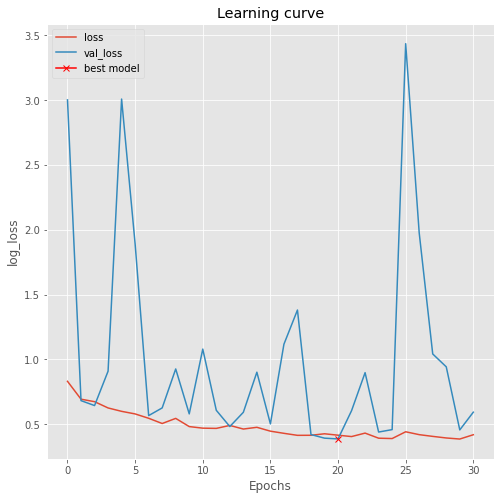

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

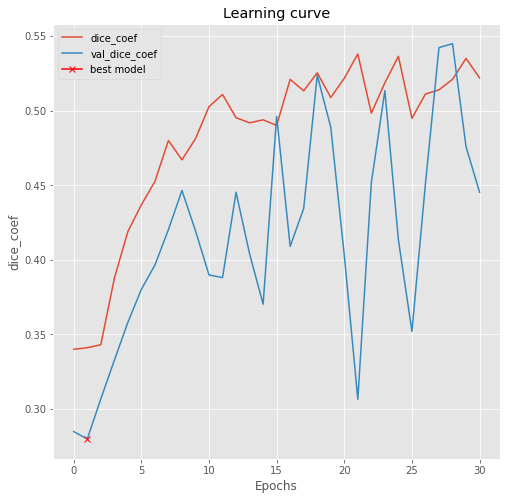

In [34]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

In [38]:
# load the best model
model.load_weights('model-Segnet.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X, y, verbose=1)

30/30 [==============================] - 58s 2s/step


[0.48840242624282837, 0.620771050453186, 0.4125345051288605, 0.421400249004364]

In [40]:
# change 3
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 27s 2s/step


In [41]:
print (classification_report(y_test.round(0).flatten().astype(int), preds_test.round(0).flatten().astype(int)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90   2947404
           1       0.63      0.39      0.48    722612

    accuracy                           0.84   3670016
   macro avg       0.75      0.67      0.69   3670016
weighted avg       0.82      0.84      0.82   3670016



In [42]:
TN, FP, FN, TP = confusion_matrix(y_test.flatten().astype(int), preds_test.round(0).flatten().astype(int)).ravel()
Confusion_Matrix = np.array([[TN, FP], [FN, TP]])
print(Confusion_Matrix)

[[3022332  250070]
 [ 203820  193794]]


In [0]:
# change 4
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

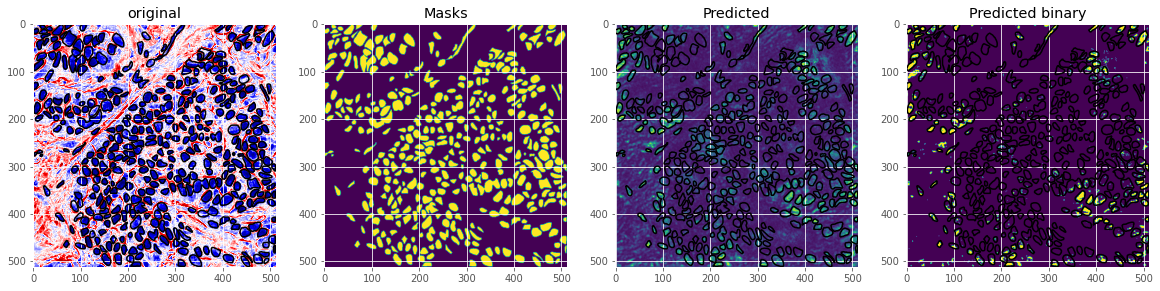

In [45]:
# Check if training data looks all right
plot_sample(X, y, preds_train, preds_train_t, ix=14)

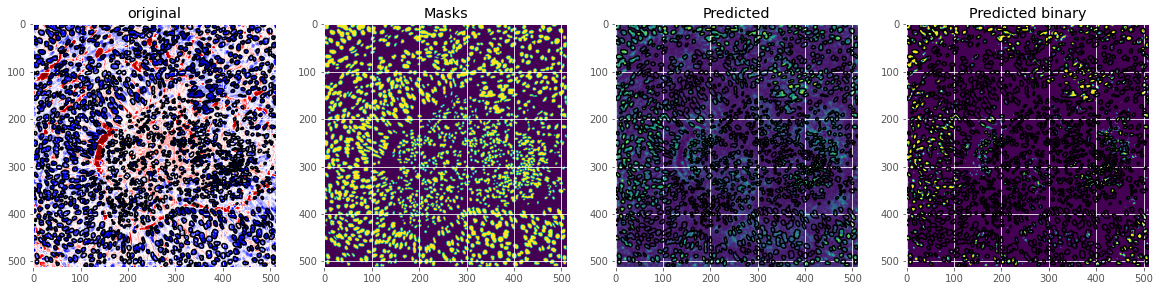

In [46]:
plot_sample(X, y, preds_train, preds_train_t)

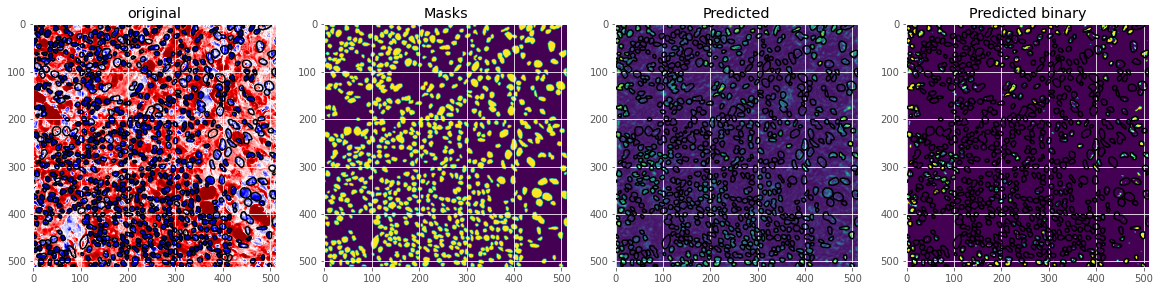

In [47]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

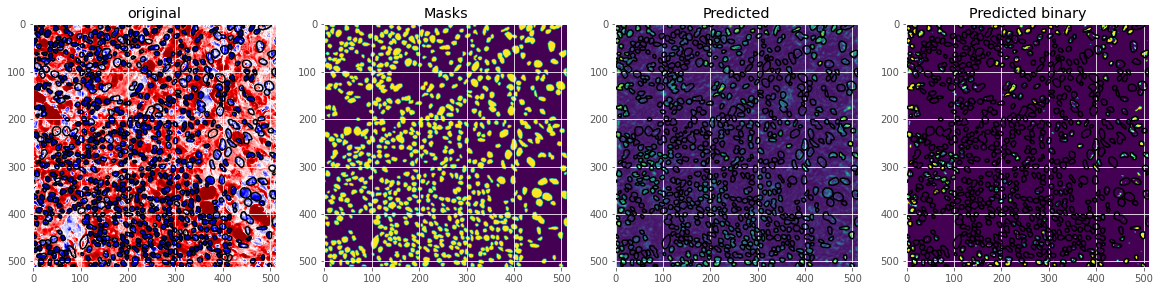

In [48]:
plot_sample(X_test, y_test, preds_test, preds_test_t)